# Starting Kit - FAIR UNIVERSE: HIGGSML UNCERTAINTY CHALLENGE

For Overview and Decsiptions of the competition, please visit the competition page

## Local Setup

#### ⚠️ Note:
If you are running this starting kit locally, you may want to use a dedicated conda env.  
[Instructions to setup a conda env](https://github.com/FAIR-Universe/HEP-Challenge/tree/master/conda)

#### ⚠️ Note:
If you are running this starting kit on MAC OS, you may want to check and install `libomp` package. 
This package is needed to run xgboost model. Follow the steps below for complete installations.

If still you are facing problems with XGBoost, you can uninstall the current xgboost and install py-xgboost in your environment

Uninstall XGBoost
```
pip uninstall xgboost
```

Install py-xgboost using conda
```
conda install py-xgboost
```

## COLAB Setup
`COLAB` determines whether this notebook is running on Google Colab.

In [1]:
COLAB = 'google.colab' in str(get_ipython())

In [2]:
if COLAB:
    # clone github repo
    !git clone --depth 1 https://github.com/FAIR-Universe/HEP-Challenge.git

    # move to the HEP starting kit folder
    %cd HEP-Challenge/

    # Install required packages
    # %pip install -r conda/requirements.txt 

In [3]:
TEST_SETTINGS = {
"systematics": {  # Systematics to use
    "tes": False, # tau energy scale
    "jes": False, # jet energy scale
    "soft_met": False, # soft term in MET
    "ttbar_scale": False, # ttbar scale factor
    "diboson_scale": False, # diboson scale factor
    "bkg_scale": False, # Background scale factor
    },
"num_pseudo_experiments" : 2, # Number of pseudo-experiments to run per set
"num_of_sets" : 1, # Number of sets of pseudo-experiments to run
} 

USE_RANDOM_MUS = True
USE_TEST_MODEL = False

## Existing Submissions
By this point you should have a clone of the repo which contains `HiggsML_Dummy_Submission.zip` which you can submit to the Competition

For more sample submissions please check `/HEP-Challenge/example_submissions/`

### Imports

In [4]:
import os
import json
import datetime
import numpy as np
from sys import path
from zipfile import ZipFile, ZIP_DEFLATED
from contextlib import closing

import matplotlib.pyplot as plt
import pandas as pd

from pathlib import Path

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
# os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

### Directories

In [6]:

root_dir = os.getcwd()
print("Root directory is", root_dir)

input_dir = os.path.join(root_dir, "input_data")
output_dir = os.path.join(root_dir, "sample_result_submission")
program_dir = os.path.join(root_dir, "ingestion_program")
score_dir = os.path.join(root_dir, "scoring_program")

if USE_TEST_MODEL:
    submission_dir = os.path.join(root_dir, "test_model")
else:
    submission_dir = os.path.join(root_dir, "sample_code_submission")

test_settings = TEST_SETTINGS.copy()

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
if USE_RANDOM_MUS:
    test_settings[ "ground_truth_mus"] = list(range(5)) # (np.random.uniform(0.1, 3, test_settings["num_of_sets"])).tolist()
    
    random_settings_file = os.path.join(output_dir, "random_mu.json")
    with open(random_settings_file, "w") as f:
        json.dump(test_settings, f)
else:
    test_settings_file = os.path.join(input_dir, "test", "settings", "data.json")
    with open(test_settings_file) as f:
        test_settings = json.load(f)

Root directory is /clusterfs/ml4hep/jvdudley/projects/FairUniverse/examples/HEP-Challenge



### Add directories to path

In [7]:
path.append(program_dir)
path.append(submission_dir)
path.append(score_dir)

***
# Internal imports
***

In [8]:
from visualization import *
from systematics import systematics

***
# Import Submission Model
***
We import a class named `Model` from the submission file (`model.py`). This `Model` class has the following methods:
- `init`: receives train set and systematics class as input
- `fit`: can be used for training
- `predict`: receives one test set and outputs a dictionary with the following keys
    - `mu_hat` : predicted mu $\hat{\mu}$
    - `delta_mu_hat`: $\Delta{\hat{\mu}}$ bound for $\mu$
    - `p16`: 16th percentile
    - `p84`: 84th percentile

In this example code, the `Model` class implements an XGBoost model which is trained to predict both the TES and the class label. You can find the code in `HEP-Challenge/sample_code_submission/model.py`. You can modify it the way you want, keeping the required class structure and functions there. More instructions are given inside the `model.py` file. If running in Collab, click the folder icon in the left sidebar to open the file browser.

### ⚠️ Note:
In real setting i.e. the challenge itself, the submitted model is initialized once with train set and systematics class and the `predict` is called multiple times, each time with a different test sets. 

In [9]:
from model import Model
from datasets import Data

***
## Data
***

### ⚠️ Note:
The data used here is a small sample data is for demonstration only to get a view of what the data looks like. 

`USE_PUBLIC_DATASET` determines whether to use a public dataset provided for the participants or use a small sample datafor quick execution of this notebook

#### ⚠️ Note:
If you have already downloaded the public_data from the competition website, make sure that it is placed in the right folder `HEP-Challenge/` so that you don't download it again. Setting `USE_PUBLIC_DATASET` to `True` will download the public_data if not found in the `HEP-Challenge` directory.

In [10]:
USE_PUBLIC_DATASET = True

`USE_PUBLIC_DATASET` determines whether to use a public dataset provided for the participants or use a small subset of the data for quick execution of this notebook

In [11]:
if USE_PUBLIC_DATASET:
    from datasets import Neurips2024_public_dataset as public_dataset
    data = public_dataset()
else:
    data = Data(input_dir)

The function loads the downloaded data in the public_data folder or downloads the data from codabench using `wget` in the absence of the downloaded data, 

In [12]:
# load train set
data.load_train_set()

[*] Loading Train data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157016124 entries, 0 to 157016123
Columns: 16 entries, PRI_lep_pt to PRI_met_phi
dtypes: float32(16)
memory usage: 9.4 GB
None
[+] Train data loaded successfully


In [ ]:
# load test sets
data.load_test_set()

***
# Visualize
***
- Visualize Train set

In [ ]:
data_vis = systematics(data.get_train_set())

train_visualize = Dataset_visualise(
    data_set=data_vis,
    columns=[
        "PRI_jet_leading_pt",
        "PRI_met",
        "DER_mass_vis",
        "DER_mass_jet_jet",
        "DER_sum_pt",
    ],
    name="Train Set",
)

In [ ]:
# Show data summary
train_visualize.examine_dataset()

In [ ]:
# Show data summary
train_visualize.histogram_dataset()

In [ ]:
train_visualize.stacked_histogram("DER_mass_vis")

In [ ]:
# Show data summary
train_visualize.pair_plots(sample_size=100)

In [ ]:
syst_train_data = data.get_syst_train_set()

In [ ]:
# Pair plots of train set with systematics
train_visualize.pair_plots_syst(syst_train_data["data"], sample_size=100)

***
# Program
***


In [12]:

from ingestion import Ingestion

ingestion = Ingestion(data)


In [13]:

# initialize submission
ingestion.init_submission(Model)

[*] Initializing Submmited Model


## Statistical Tools
In the process of data fitting using our ingestion module, there are two primary arguments that control how the fit is performed: stat_only and syst_settings.
- `stat_only (bool, optional)`: This argument, when set to True, forces the fitting process to compute statistics-only results. This means that only statistical uncertainties are considered, and all systematic uncertainties are ignored.
- `syst_settings (dict, optional)`: This argument is a dictionary that specifies the systematic settings, indicating whether to fix certain systematics during the fitting process. Each entry in the dictionary represents a different systematic uncertainty, with a boolean value indicating whether it should be **fixed** (True) or allowed to **float** (False).

Note that the `syst_settings` is used to only control the systematics that are allowed to float during the fitting process. It is different from the `TEST_SETTINGS['systematics']` which is used to specify the systematics to be used in the test set generation.

[*] Calling fit method of submitted model
[*] Loading Train data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157016124 entries, 0 to 157016123
Columns: 16 entries, PRI_lep_pt to PRI_met_phi
dtypes: float32(16)
memory usage: 9.4 GB
None
[+] Train data loaded successfully
Full data:  (144035999, 28)
Full Labels:  (144035999,)
Full Weights:  (144035999,)
sum_signal_weights:  965.9737786234093
sum_bkg_weights:  945854.5141764001
 
 
Full size of the data is 144035999
Train size is 72017999
Test size is 72018000
Full size of the data is 72018000
Train size is 36009000
Test size is 36009000
Training Set:
-------- 
  Data Shape:          (72017999, 28)
  Labels Shape:        (72017999,)
  Weights Shape:       (72017999,)
  Sum Signal Weights:  965.97
  Sum Background Weights: 945854.51


Validation Set:
---------- 
  Data Shape:          (36009000, 28)
  Labels Shape:        (36009000,)
  Weights Shape:       (36009000,)
  Sum Signal Weights:  965.97
  Sum Background Weights: 945854.51


2024-10-28 15:32:20.324254: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-28 15:32:20.324287: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-28 15:32:20.325422: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-28 15:32:20.332772: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-28 15:32:24.809077:

2 Physical GPUs, 1 Logical GPUs
Model is TF NN
test_data.shape in NeuralNetwork.predict (72017999, 28)
70331/70331 [==============================] - 74s 1ms/step
Done. result.shape: (72017999,)
computing scores in stat_analysis.nominal_histograms
test_data.shape in NeuralNetwork.predict (36009000, 28)
35166/35166 [==============================] - 37s 1ms/step
Done. result.shape: (36009000,)
scores computed
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -8253795.615414996
        x: [ 1.026e+00]
      nit: 1
      jac: [ 0.000e+00]
 hess_inv: [[1]]
     nfev: 6
     njev: 3 dict_keys(['fun', 'jac', 'hess_inv', 'nfev', 'njev', 'status', 'success', 'message', 'x', 'nit']) [1.02601835] [[1]]


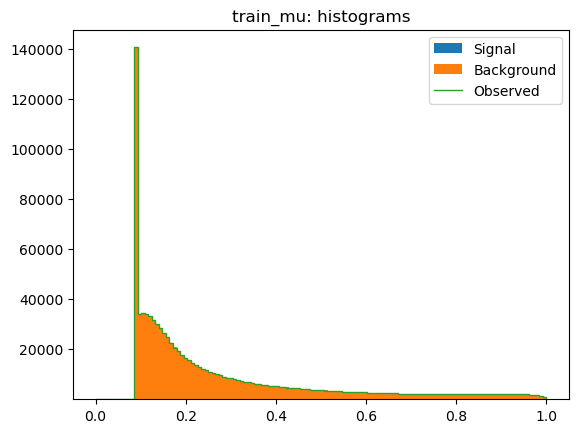

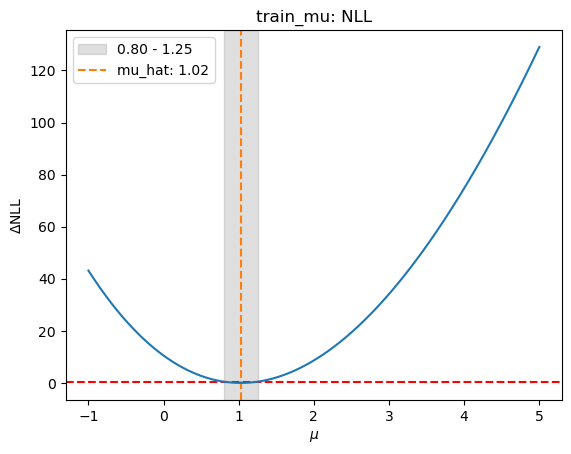

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -8253795.615414996
        x: [ 1.026e+00]
      nit: 1
      jac: [ 0.000e+00]
 hess_inv: [[1]]
     nfev: 6
     njev: 3 dict_keys(['fun', 'jac', 'hess_inv', 'nfev', 'njev', 'status', 'success', 'message', 'x', 'nit']) [1.02601835] [[1]]


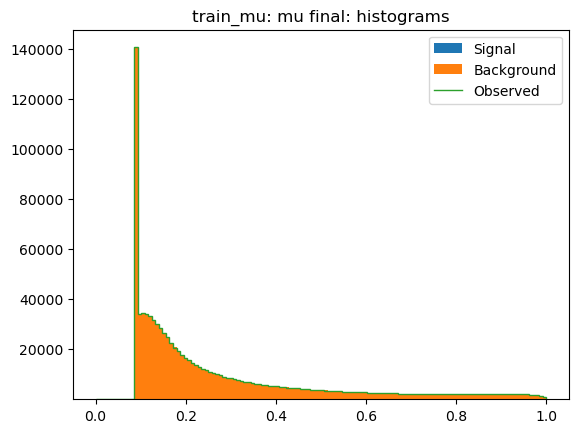

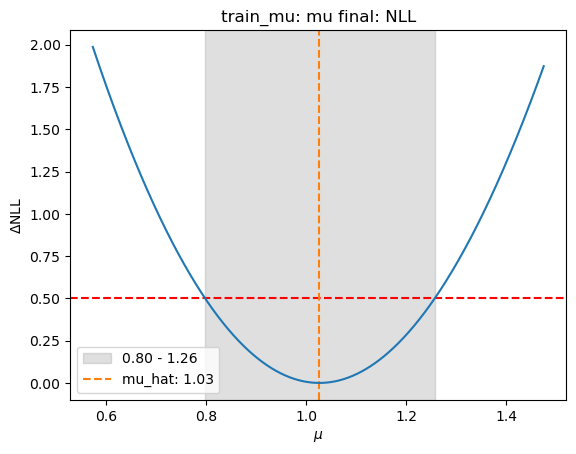

Training Results:
-------- Results:
	mu_hat : 1.026141352874026
	delta_mu_hat : 0.45860441900045856
	p16 : 0.7980104316737979
	p84 : 1.2566148506742565


test_data.shape in NeuralNetwork.predict (36009000, 28)
35166/35166 [==============================] - 37s 1ms/step
Done. result.shape: (36009000,)
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -8253709.071056398
        x: [ 1.002e+00]
      nit: 2
      jac: [ 0.000e+00]
 hess_inv: [[ 1.063e-02]]
     nfev: 32
     njev: 16 dict_keys(['fun', 'jac', 'hess_inv', 'nfev', 'njev', 'status', 'success', 'message', 'x', 'nit']) [1.00199317] [[0.01063023]]


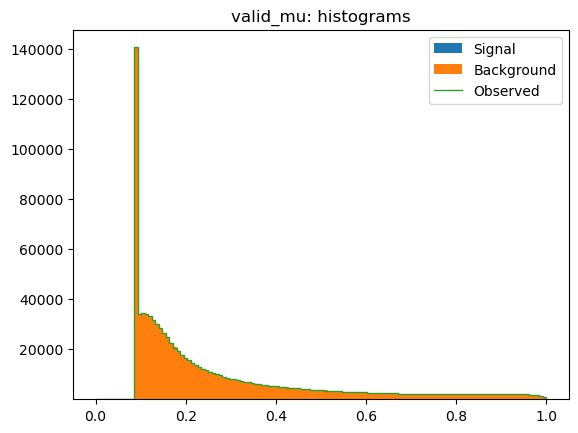

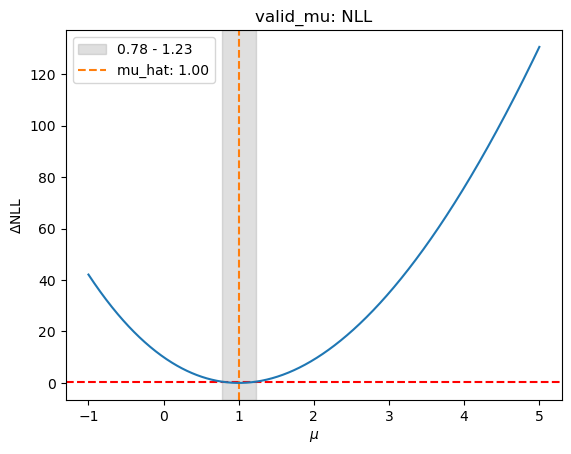

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -8253709.071056398
        x: [ 1.002e+00]
      nit: 2
      jac: [ 0.000e+00]
 hess_inv: [[ 1.063e-02]]
     nfev: 32
     njev: 16 dict_keys(['fun', 'jac', 'hess_inv', 'nfev', 'njev', 'status', 'success', 'message', 'x', 'nit']) [1.00199317] [[0.01063023]]


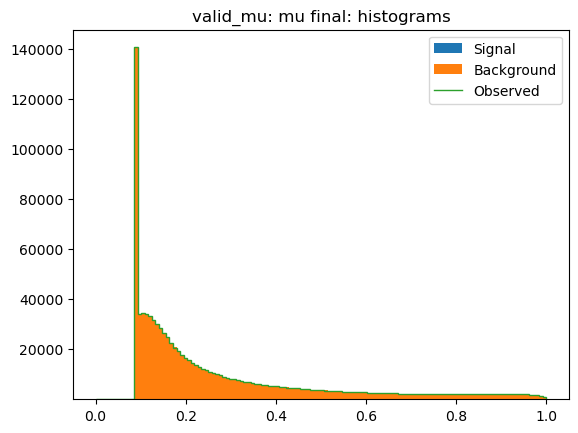

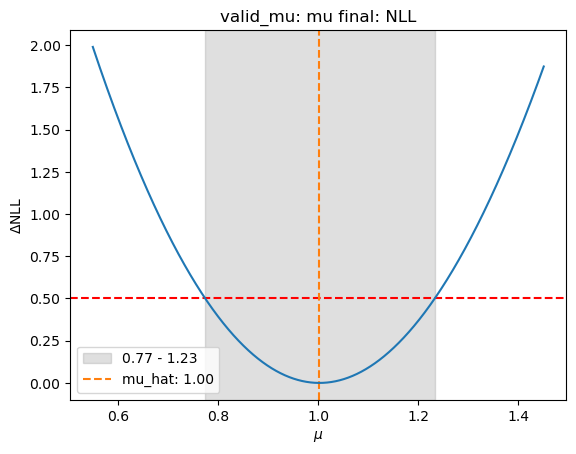

Validation Results:
---------- Results:
	mu_hat : 1.0022074279500022
	delta_mu_hat : 0.45842422080045875
	p16 : 0.774166605849774
	p84 : 1.2325908266502328


test_data.shape in NeuralNetwork.predict (36009000, 28)
35166/35166 [==============================] - 37s 1ms/step
Done. result.shape: (36009000,)
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -8253601.749033799
        x: [ 1.000e+00]
      nit: 1
      jac: [ 0.000e+00]
 hess_inv: [[1]]
     nfev: 18
     njev: 9 dict_keys(['fun', 'jac', 'hess_inv', 'nfev', 'njev', 'status', 'success', 'message', 'x', 'nit']) [0.99999504] [[1]]


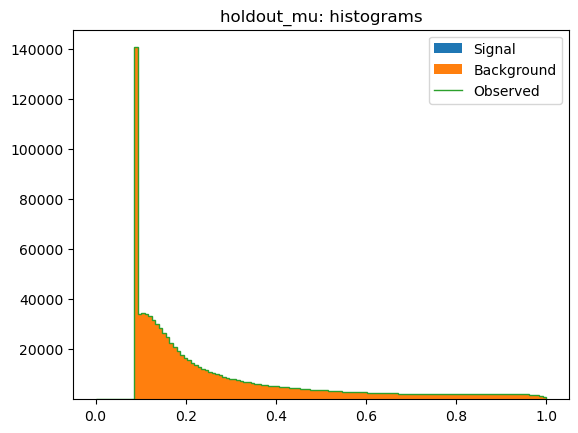

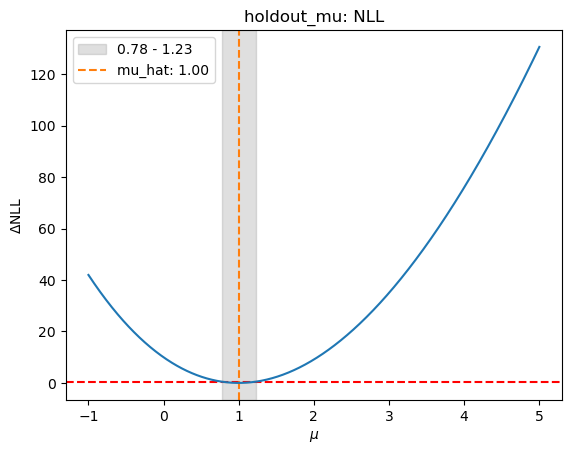

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -8253601.749033799
        x: [ 1.000e+00]
      nit: 1
      jac: [ 0.000e+00]
 hess_inv: [[1]]
     nfev: 18
     njev: 9 dict_keys(['fun', 'jac', 'hess_inv', 'nfev', 'njev', 'status', 'success', 'message', 'x', 'nit']) [0.99999504] [[1]]


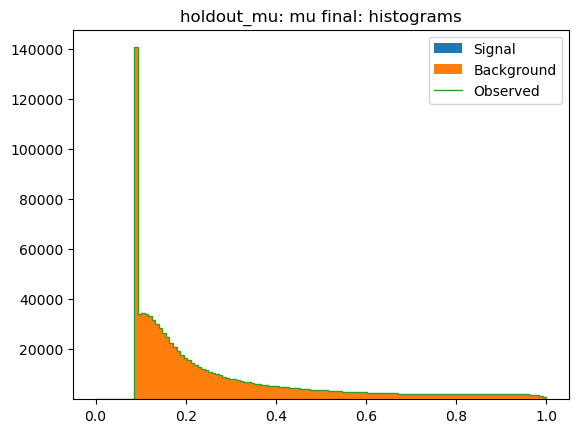

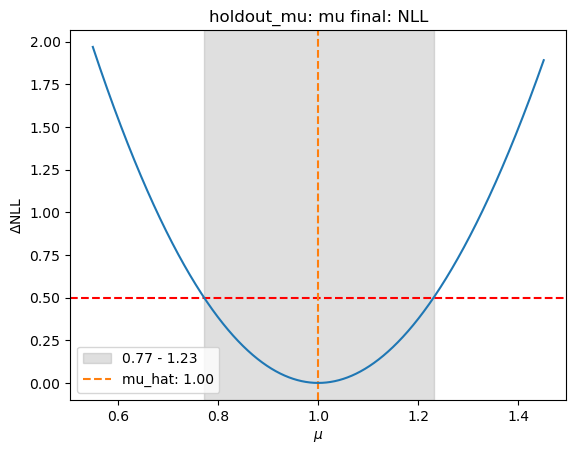

Holdout Results:
------- Results:
	mu_hat : 0.9999549504499999
	delta_mu_hat : 0.4586945181004588
	p16 : 0.7718240292497717
	p84 : 1.2305185473502305


computing scores in stat_analysis.nominal_histograms
test_data.shape in NeuralNetwork.predict (72018000, 28)


2024-10-28 15:38:21.572450: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.51GiB (rounded to 8066016000)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-10-28 15:38:21.572501: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-10-28 15:38:21.572513: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 20, Chunks in use: 20. 5.0KiB allocated for chunks. 5.0KiB in use in bin. 104B client-requested in use in bin.
2024-10-28 15:38:21.572521: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 14, Chunks in use: 12. 7.2KiB allocated for chunks. 6.2KiB in use in bin. 4.7KiB client-requested in use in bin.
2024-10-28 15:38:21.57252

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [14]:

# fit submission
ingestion.fit_submission()

In [ ]:
ingestion.model.stat_analysis.nominal_histograms(1, apply_syst=True)

In [ ]:
# load test set
data.load_test_set()

In [ ]:

# predict submission
ingestion.predict_submission(test_settings)

In [ ]:
ingestion.compute_result()

In [ ]:

# save result
!rm -rf $output_dir/*
ingestion.save_result(output_dir)

***
# Likelihood plots
***

In [ ]:
from tqdm import tqdm

from systematics import postprocess, systematics
from pathlib import Path
# from systematics import LHC_NUMBERS as LHC_NUMBERS_NEW

In [ ]:
def NLL(mu, observed, expected_sig, expected_bkgd, scale=1, epsilon=1e-30):
    # need to double check the scaling
    expected = scale * (mu * expected_sig + expected_bkgd)
    return np.sum(expected - observed * np.log(expected + epsilon))

In [ ]:
def NLLarray(mus, observed, expected_sig, expected_bkgd, epsilon=1e-30):
    expected = (mus[:, None] * expected_sig + expected_bkgd)
    return (expected - observed * np.log(expected + epsilon)).sum(axis=1)

In [ ]:
def get_results(mus, nlls):
    mu_hat = mus[np.argmin(nlls)]
    one_sigma = mus[(nlls - np.min(nlls)) < 0.5]
    return mu_hat, (one_sigma[0], one_sigma[-1])

In [ ]:
# check sum of weights after post-cuts
def check_weights_post_syst(data):
    syst_data = systematics(data)
    counts = {
        name: syst_data['weights'][syst_data['detailed_labels'] == name].sum() for name in LHC_NUMBERS
    }
    return pd.Series(counts)

In [ ]:
def format_test_as_train(data_set=None):
    joined_data = []
    if data_set is None:
        data.load_test_set()
        data_set = data.get_test_set()
    for name, df in data_set.items():
        label = 1. if name == 'htautau' else 0.
        joined_data.append(
            df.assign(labels=label, detailed_labels=name)
        )
    joined_data = pd.concat(joined_data, axis=0, ignore_index=True, copy=False)
    separated_data = {
        'data': joined_data.drop(columns=['labels', 'detailed_labels', 'weights']),
        'labels': joined_data['labels'],
        'weights': joined_data['weights'],
        'detailed_labels': joined_data['detailed_labels'],
    }
    return separated_data

In [ ]:
num_bins = 128
hist_bins = np.linspace(0, 1, num_bins+1)

In [ ]:

mus = np.linspace(0, 4, 10**4) # negtive mu breaks when using labels in place of scores

In [ ]:
LHC_NUMBERS = {
    "ztautau": 3544019,
    "diboson": 40590,
    "ttbar": 158761,
    "htautau": 3639,
}

In [ ]:
ingestion.model.stat_analysis.holdout_scores = None
tmp_results = ingestion.model.stat_analysis.vary_hist_bins(
    bins_iter=tqdm(range(1, 11)),
    data_set=format_test_as_train(data.get_test_set()),
    mu_true=1,
    plot_title='Without post-cuts',
)

In [ ]:
tmp_results_syst = ingestion.model.stat_analysis.vary_hist_bins(
    bins_iter=tqdm(range(1, 11)),
    data_set=format_test_as_train(data.get_test_set()),
    apply_syst=True,
    mu_true=1,
    plot_title='With post-cuts',
)

In [ ]:
# rescale intervals to estimate the uncertainty with weighted events
tmp_width_scale = np.sqrt(
    sum(
        (df['weights']**2).sum() for df in data.get_test_set().values()
    ) / sum(
        df['weights'].sum() for df in data.get_test_set().values()
    )
)
tmp_inv_var_weighted_mean, tmp_weighted_var_inv = np.average(
    [result['prediction']['mu_hat'] for result in tmp_results],
    weights=[1 / (tmp_width_scale * result['prediction']['delta_mu_hat'] / 2)**2 for result in tmp_results],
    returned=True,
)
tmp_weighted_var = 1 / tmp_weighted_var_inv
tmp_mean_syst, tmp_var_inv_syst = np.average(
    [result['prediction']['mu_hat'] for result in tmp_results_syst],
    weights=[1 / (tmp_width_scale * result['prediction']['delta_mu_hat'] / 2)**2 for result in tmp_results_syst],
    returned=True,
)
tmp_var_syst = 1 / tmp_var_inv_syst

plt.figure(figsize=(12, 10))
plt.errorbar(
    [result['prediction']['mu_hat'] for result in tmp_results],
    [result['bins'] for result in tmp_results],
    xerr=[tmp_width_scale * result['prediction']['delta_mu_hat'] / 2 for result in tmp_results],
    fmt='.',
    label='without cuts',
    alpha=0.5,
)
plt.errorbar(
    [result['prediction']['mu_hat'] for result in tmp_results_syst],
    [result['bins'] for result in tmp_results_syst],
    xerr=[tmp_width_scale * result['prediction']['delta_mu_hat'] / 2 for result in tmp_results_syst],
    fmt='.',
    label='with cuts',
    alpha=0.5,
)
plt.axvline(
    tmp_inv_var_weighted_mean,
    # color='red',
    label='mean $\hat \mu$ without cuts',
)
plt.axvspan(
    tmp_inv_var_weighted_mean - np.sqrt(tmp_weighted_var),
    tmp_inv_var_weighted_mean + np.sqrt(tmp_weighted_var),
    # color='red',
    alpha=0.2,
)
plt.axvline(
    tmp_mean_syst,
    color='C1',
    label='mean $\hat \mu$ with cuts',
)
plt.axvspan(
    tmp_mean_syst - np.sqrt(tmp_var_syst),
    tmp_mean_syst + np.sqrt(tmp_var_syst),
    color='C1',
    alpha=0.2,
)
plt.axvline(1, color='black', label='True $\mu$')
plt.axvline(1.05, color='black', linestyle='--', label='1.05')
# plt.axvline(np.mean([result['prediction']['mu_hat'] for result in tmp_results]), color='red', label='Mean $\hat \mu$')
# plt.axvspan(
#     np.mean([result['prediction']['mu_hat'] for result in tmp_results]) - np.std([result['prediction']['mu_hat'] for result in tmp_results]) / np.sqrt(len(tmp_results)),
#     np.mean([result['prediction']['mu_hat'] for result in tmp_results]) + np.std([result['prediction']['mu_hat'] for result in tmp_results]) / np.sqrt(len(tmp_results)),
#     color='red',
#     alpha=0.2,
#     label='$ 1 \sigma $'
# )
plt.xlabel('$\mu$')
plt.ylabel('Number of bins')
# plt.yscale('log')
plt.legend()
plt.title('Full test set')

In [ ]:
tmp_luminosity_scale = .1

tmp_holdout_set = ingestion.model.stat_analysis.holdout_set.copy()
ingestion.m['weights'] == tmp_luminosity_scale * tmp_holdout_set['weights'].copy()

tmp_data_set = format_test_as_train(data.get_test_set()).copy()
tmp_data_set['weights'] == tmp_luminosity_scale * tmp_data_set['weights'].copy()

# ingestion.model.stat_analysis.holdout_set['weights'] *= tmp_luminosity_scale

results_low_luminosity = ingestion.model.stat_analysis.vary_hist_bins(
    # bins_iter=tqdm(range(1, 11)),
    data_set=tmp_data_set,
    mu_true=1,
    plot_title='Without post-cuts',
)
results_low_luminosity_syst = ingestion.model.stat_analysis.vary_hist_bins(
    # bins_iter=tqdm(range(1, 11)),
    data_set=tmp_data_set,
    mu_true=1,
    apply_syst=True,
    plot_title='With post-cuts',
)

In [ ]:
tmp_data_set['weights']

## Checking event counts

In [ ]:
data.load_train_set()

In [ ]:
all_weighted_data = data.get_train_set().copy()

In [ ]:
for k, v in all_weighted_data.items():
    print(k, type(v))

In [ ]:
all_weighted_data['detailed_labels'] = np.array(all_weighted_data['detailed_labels'])

In [ ]:
asimov_data = format_test_as_train(data.get_test_set())

In [ ]:
# {name: all_weighted_data['weights'][all_weighted_data['detailed_labels'] == name] for name in LHC_NUMBERS}
# plt.figure(figsize=(16, 10))
plt.subplots(2, 2, figsize=(16, 10))
for j, name in enumerate(LHC_NUMBERS, start=1):
    plt.subplot(2, 2, j)
    tmp_weights = all_weighted_data['weights'][all_weighted_data['detailed_labels'] == name]
    print(name, tmp_weights.shape, tmp_weights.mean(), tmp_weights.std())
    print(pd.Series(tmp_weights).value_counts())
    plt.hist(tmp_weights, bins=100, density=False, alpha=0.5, label=name)
    plt.title(name)
# plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('weights')
    plt.ylabel('count')
    plt.legend()
# plt.title('weighted data')


In [ ]:
(all_weighted_data['weights'][all_weighted_data['detailed_labels'] == 'htautau'] == 0).sum(), (all_weighted_data['detailed_labels'] == 'htautau').sum()

In [ ]:
counts_df = pd.DataFrame.from_dict(
    {
        name: {
            # 'LHC_NUMBERS (old)': LHC_NUMBERS[name],
            'template sum of weights': all_weighted_data['weights'][all_weighted_data['detailed_labels'] == name].sum(),
            'asimov sum of weights': asimov_data['weights'][asimov_data['detailed_labels'] == name].sum(),
            'template num events': (all_weighted_data['detailed_labels'] == name).sum(),
            'asimov num events': (asimov_data['detailed_labels'] == name).sum(),
            'template average weight': all_weighted_data['weights'][all_weighted_data['detailed_labels'] == name].mean(),
            'asimov average weight': asimov_data['weights'][asimov_data['detailed_labels'] == name].mean(),
        }
        for name in LHC_NUMBERS
    },
    orient='index',
)

In [ ]:
counts_df.T.style.format(precision=6)

In [ ]:
counts_df.index

In [ ]:
counts_df['template sum post cuts'] = check_weights_post_syst(data.get_train_set())
counts_df['asimov sum post cuts'] = check_weights_post_syst(format_test_as_train(data.get_test_set()))

In [ ]:
counts_df.assign(diff=lambda df: df['asimov sum post cuts'] - df['template sum post cuts']).T.assign(sum=lambda df: df.sum(1)).style.format(precision=3)

## Comparison

Use scores and weights from Sascha

In [ ]:
bresult = [] # list of dictionaries of results of varying num_bins

In [ ]:
sresults = {}

In [ ]:
# sascha_dir = Path('/global/ml4hep/spss/jvdudley/physicsData/FairUniverse/comparison_Sascha/Fair_Universe_Comparison_Data/')
sascha_dir = Path('/global/ml4hep/spss/sdiefenbacher/Fair_Universe/comparison/comparison_templates_data_07_23_seed45/')
# sprefix = 'Run_9'

In [ ]:
for file in sascha_dir.glob('eval*.npy'):
    # if file.stem.startswith('Run'): continue
    print(file.stem)

In [ ]:
def sread(pattern, dir=sascha_dir):
    return {file.stem: np.load(file) for file in dir.glob(pattern)}

In [ ]:
sread('eval*.npy')

In [ ]:
sread('Run_0*.npy')

In [ ]:
for pattern in ('eval*.npy', 'Run_0*.npy', '*bkg*.npy'):
    plt.hist()

In [ ]:
stdata = {}
sedata = {}

sdata = {}

In [ ]:
# for pattern in ('*sig*.npy', '*bkg*.npy', '*Run_*.npy'):
for name, data in sread('*.npy').items():
    # print(name, data.shape)
    if name.endswith('_weights'):
        tmpsuffix = 'weights'
    elif name.endswith('_values'):
        tmpsuffix = 'values'
    else:
        raise ValueError(f'{name} does not end with "_weights" or "_values"')
    tmpprefix = name.removesuffix('_weights').removesuffix('_values')
    if tmpprefix.startswith('Run_'):
        tmpprefix = int(tmpprefix.removeprefix('Run_').removesuffix('eval'))
    if tmpprefix not in sdata:
        sdata[tmpprefix] = {}
    sdata[tmpprefix][tmpsuffix] = data

In [ ]:
for name, data in sread('*Run_*.npy').items():
    tmpprefix = name.removesuffix('_weights').removesuffix('_values')
    if tmpprefix not in sedata:
        sedata[tmpprefix] = {}
    sedata[tmpprefix][name.removeprefix(tmpprefix + '_')] = data

In [ ]:
sedata['Run_0eval'].keys()

In [ ]:
sascha_copy = {file.stem: np.load(file) for file in sascha_dir.glob('*bkg*.npy')}
sascha_data = {}


In [ ]:
for name in sascha_copy:
    tmp_prefix = name.removesuffix('_values').removesuffix('_weights')
    if tmp_prefix not in sascha_data:
        sascha_data[tmp_prefix] = {}
    sascha_data[tmp_prefix][name.removeprefix(tmp_prefix + '_')] = sascha_copy[name]
del sascha_copy

In [ ]:
sascha_hist = {name: np.histogram(data['values'], bins=hist_bins, weights=data['weights'])[0] for name, data in sascha_data.items()}

In [ ]:
shist = {name: np.histogram(data['values'], bins=hist_bins, weights=data['weights'])[0] for name, data in tqdm(sdata.items())}

In [ ]:
svar = {name: np.histogram(data['values'], bins=hist_bins, weights=data['weights']**2)[0] for name, data in tqdm(sdata.items())}

In [ ]:
sthist = {name: np.histogram(data['values'], bins=hist_bins, weights=data['weights'])[0] for name, data in stdata.items()}
sehist = {name: np.histogram(data['values'], bins=hist_bins, weights=data['weights'])[0] for name, data in sedata.items()}

In [ ]:
(np.sqrt(shist['template_sig'] + shist['template_bkg']) / np.sqrt((svar['template_sig'] + svar['template_bkg']))).min()

In [ ]:
plt.stairs(
    np.sqrt(shist['template_sig'] + shist['template_bkg']),
    hist_bins,
    label='Poisson uncertainty',
    # color='blue',
    alpha=0.5,
    fill=True,
)
plt.stairs(
    np.sqrt(svar['template_sig'] + svar['template_bkg']),
    hist_bins,
    label='MC uncertainty',
    # color='red',
    alpha=0.5,
    fill=True,
)
plt.legend()

In [ ]:
plt.figure(figsize=(12, 10))
plt.axvline(
    hist_bins[shist['template_sig'].argmax()] + (hist_bins[1] - hist_bins[0]) / 2,
    color='red',
    linestyle='--',
    label='max sig',
    alpha=0.5,
)
plt.axvline(
    hist_bins[(shist['template_sig'] / shist['template_bkg']).argmax()] + (hist_bins[1] - hist_bins[0]) / 2,
    color='red',
    linestyle=':',
    label='max sig/bkg',
    alpha=0.5,
)
# plt.hist(
#     [hist_bins[:-1],] * 2,
#     hist_bins,
#     weights=[hist for name, hist in shist.items() if isinstance(name, str)],
#     alpha=0.5,
#     label=[name for name in shist if isinstance(name, str)],
#     histtype='barstacked',
# )
# tmp_vals = 0
# tmp_baseline = 0
# for sb in ('template_bkg', 'template_sig'):
#     tmp_vals += shist[sb]
#     plt.stairs(
#         tmp_vals,
#         hist_bins,
#         alpha=0.5,
#         label=sb,
#         baseline=tmp_baseline,
#         fill=True,
#     )
#     tmp_baseline += shist[sb]
plt.stairs(
    shist['template_sig'],
    hist_bins,
    alpha=0.5,
    label='sig',
    fill=True,
)
plt.errorbar(
    (hist_bins[:-1] + hist_bins[1:]) / 2,
    shist['template_sig'], # + shist['template_bkg']
    1 * np.sqrt(svar['template_sig'] + svar['template_bkg']),
    fmt=',',
    color='black',
    # drawstyle='steps-mid',
    label='bkg+sig uncertainty',
    alpha=0.5,
)
for name, hist in shist.items():
    if isinstance(name, str):
        continue
    plt.stairs( # hist(
        hist - shist['template_bkg'], # hist_bins[:-1],
        hist_bins,
        # weights=hist - shist['template_bkg'],
        alpha=0.01,
        # label=name,
        # histtype='step',
    )
# plt.yscale('log')
# plt.xlim(.9, 1)
# plt.ylim(4e1, 1.3e3)
plt.grid()
plt.legend()
plt.title('pseudoexperiments - bkg template')

In [ ]:
sascha_data.keys()

In [ ]:
# sascha_nlls = [
#     NLL(
#         mu,
#         sascha_hist[sprefix + 'eval'],
#         sascha_hist[sprefix + 'template_sig'],
#         sascha_hist[sprefix + 'template_bkg'],
#     ) for mu in mus
# ]
sascha_nlls = NLLarray(
    mus,
    shist[0],
    shist['template_sig'],
    shist['template_bkg'],
)

In [ ]:
sascha_one_sigma = np.array(mus)[(sascha_nlls - min(sascha_nlls)) < 0.5]

In [ ]:
sresults[sprefix] = (sascha_one_sigma[0], sascha_one_sigma[-1])

In [ ]:
plt.plot(mus, sascha_nlls - min(sascha_nlls))
plt.axhline(.5, color='black', linestyle='--')
plt.axvline(mus[np.argmin(sascha_nlls)], color='C1', label=f'mu_hat: {mus[np.argmin(sascha_nlls)]:.2f}')
# plt.axvline(sascha_one_sigma[0], color='r', label=f'p16: {sascha_one_sigma[0]:.2f}')
# plt.axvline(sascha_one_sigma[-1], color='r', label=f'p84: {sascha_one_sigma[-1]:.2f}')
plt.axvspan(sascha_one_sigma[0], sascha_one_sigma[-1], color='grey', alpha=0.5, label=f'p16-p84: {sascha_one_sigma[0]:.2f}-{sascha_one_sigma[-1]:.2f}')
# plt.axvline(1.45, color='C2', label='mu_hat (Sascha)')
# plt.axvline(1.3952, color='C3', label='mu_hat (Yulei)')
plt.axvline(1, color='black', label='mu_true')
# plt.plot(mus, 5.1 * (mus - mus[np.argmin(sascha_nlls)])**2, label='(mu - mu_hat)^2')
plt.ylim(0, 2)
plt.xlabel('mu')
plt.ylabel('NLL - min(NLL)')
plt.legend()
plt.title('Comparison:' + sprefix)

In [ ]:
sresults = {}

In [ ]:
for name, hist in tqdm(shist.items(), 'computing results from histograms'):
    # print(name)
    if isinstance(name, str):
        continue
    snlls = NLLarray(mus, hist, shist['template_sig'], shist['template_bkg'])
    #     NLL(
    #         mu,
    #         hist,
    #         shist['template_sig'],
    #         shist['template_bkg'],
    #     ) for mu in mus
    # ]
    sresults[name] = get_results(mus, snlls)

In [ ]:
intervals = np.array([t for _, t in sresults.values()])

In [ ]:
assert mus[1] < intervals.min(), f'mus starts too high'
print(f'{mus[1]:.3f} < {intervals.min():.3f}')
assert mus[-2] > intervals.max(), f'mus ends too low'
print(f'{mus[-2]:.3f} > {intervals.max():.3f}')


In [ ]:
# bresult[num_bins] = (intervals.mean(), ((intervals[:, 0] < 1) & (intervals[:, 1] > 1)).mean())
bresult.append({
    'mean': intervals.mean(),
    'stderr': intervals.mean(1).std() / np.sqrt(intervals.shape[0]),
    'coverage': ((intervals[:, 0] < 1) & (intervals[:, 1] > 1)).mean(),
    'num_pseudo_experiments': intervals.shape[0],
    'num_bins': num_bins,
})

# print(f'mean: {bresult[num_bins][0]:.3f}, coverage: {bresult[num_bins][1]:.3f}')
print(bresult[-1])

In [ ]:
plt.figure(figsize=(12, 10))
plt.hlines(
    [name for name in sresults],
    [p16 for _, (p16, _) in sresults.values()],
    [p84 for _, (_, p84) in sresults.values()],
)
# plot mu_true: currently 1
plt.axvline(1, color='black', label=f'mu_true=1')
# plot mu_hat mean
plt.axvline(bresult[-1]['mean'], color='r', label=f'mu_hat mean={bresult[-1]["mean"]:.3f}')
# plot mu_hat stderr
plt.axvspan(
    bresult[-1]['mean'] - bresult[-1]['stderr'],
    bresult[-1]['mean'] + bresult[-1]['stderr'],
    color='r',
    alpha=0.25,
    label=f'mu_hat stderr={bresult[-1]["stderr"]:.3f}',
)
plt.xlabel('mu')
plt.ylabel('pseudo-experiment')
plt.title(f'{num_bins} histogram bins: coverage={bresult[-1]["coverage"]:.3f}')
plt.legend()

In [ ]:
# bresult plots of mean±stderr and coverage vs num_bins
fig = plt.figure(figsize=(12, 10))
plt.errorbar(
    [b['mean'] for b in bresult],
    [b['num_bins'] for b in bresult],
    xerr=[b['stderr'] for b in bresult],
    fmt='o',
    label='mu_hat',
    alpha=0.5,
)
plt.axvline(1, color='black', label='mu_true')
plt.yscale('log')
plt.ylabel('num_bins')
plt.xlabel('mu_hat')
plt.twiny()
plt.errorbar(
    [b['coverage'] for b in bresult],
    [b['num_bins'] for b in bresult],
    xerr=[np.sqrt(.682689 * (1 - .682689) / b['num_pseudo_experiments']) for b in bresult],
    fmt='ro',
    label='coverage',
    alpha=0.5,
)
plt.axvline(.682689, color='r', linestyle='--', label='1 sigma')
# plt.axhspan(
#     .682689 - np.sqrt(.682689 * (1 - .682689) / bresult[-1]['num_pseudo_experiments']),
#     .682689 + np.sqrt(.682689 * (1 - .682689) / bresult[-1]['num_pseudo_experiments']),
#     color='grey',
#     alpha=0.25,
# )
plt.xlabel('coverage')
plt.suptitle('Results of varying num_bins')
plt.text(.557, .9, sascha_dir.stem)
fig.legend()

In [ ]:
cresults = {
    'Jordan': {
        'Run_0': (0.8823613236132362, 1.1882118821188212),
        'Run_1': (0.8945064450644507, 1.1997444974449745),
        'Run_2': (0.8033480334803348, 1.115131151311513),
        'Run_3': (0.9987899878998789, 1.3043430434304342),
        'Run_4': (0.9687946879468795, 1.2695876958769587),
        'Run_5': (0.9235392353923539, 1.232959829598296),
        'Run_6': (1.180021800218002, 1.4898273982739827),
        'Run_7': (1.091540915409154, 1.4003315033150332),
        'Run_8': (1.0722382223822238, 1.378928789287893),
        'Run_9': (1.0410879108791087, 1.3475684756847568),
    },
    'Sascha': {
        'Run_0': (0.901194159732266, 1.2062761636214896),
        'Run_1': (0.8894361103293542, 1.1950205736920794),
        'Run_2': (0.8156946813859971, 1.1266712540266663),
        'Run_3': (0.9982769846663299, 1.3037225824265635),
        'Run_4': (0.9674725796855451, 1.2681422564378708),
        'Run_5': (0.9341876695842286, 1.2431236399605807),
        'Run_6': (1.210834505642529, 1.5191684157141783),
        'Run_7': (1.1024395216920113, 1.4106339865777082),
        'Run_8': (1.0826025589257644, 1.388693180595792),
        'Run_9': (1.0624547927260337, 1.3678220195383683),
    },
    'Yulei': [
        (0.8641240477713032, 1.1685347528269672),
        (0.8534984694263906, 1.1566380803920224),
        (0.8163559424937542, 1.1282676529144529),
        (1.0138248845573359, 1.3189941669186172),
        (0.9976235681984136, 1.2983202394845823),
        (0.8384660075098151, 1.145517502230531),
        (1.0601399318867162, 1.3669774991943608),
        (1.0648479946635852, 1.3725732313530639),
        (1.1072575393906805, 1.4142756561289402),
        (0.9287805137600891, 1.2318307738852956),
    ],
}

In [ ]:
cresults['Yulei'] = {f'Run_{j}': vals for j, vals in enumerate(cresults['Yulei'])}

In [ ]:
plt.figure(figsize=(12, 10))
plt.axvline(1, color='black', label='mu_true=1')
for j, (name, results) in enumerate(cresults.items()):
    plt.hlines(
        [int(run.removeprefix('Run_')) + j/10 for run in results],
        [p16 for p16, _ in results.values()],
        [p84 for _, p84 in results.values()],
        color=f'C{j}',
        label=name,
    )
plt.xlabel('mu')
plt.ylabel('Run_[number]')
plt.legend()
plt.title('Coverage comparison')

## Predict mu for test data

This does not include postselection cuts

In [ ]:
# read data: train, valid, test
train_set = ingestion.model.training_set.copy()
valid_set = ingestion.model.stat_analysis.holdout_set.copy()
ingestion.data.load_test_set()
test_set = ingestion.data.get_test_set().copy()


In [ ]:
pseudo_exp_data = ingestion.data.generate_pseudo_exp_data(seed=3141592653)

In [ ]:
assert (pseudo_exp_data['weights'] == 1).all(), 'pseudo experiment data weights are not all one'

In [ ]:
counts_df['num unweighted events'] = {name: df.shape[0] for name, df in data.get_test_set().items()}

In [ ]:
counts_df.T.style.format(precision=3, thousands=',').format(precision=6, subset=('average weight',))

In [ ]:
sums_by_type = {
    name: (
        # all_weighted_data['weights'][all_weighted_data['detailed_labels'] == name].sum(),
        train_set['weights'][train_set['detailed_labels'] == name].sum(),
        valid_set['weights'][valid_set['detailed_labels'] == name].sum(),
    )
    for name in LHC_NUMBERS
}

In [ ]:
sums_by_type['bkgd'] = (
    all_weighted_data['weights'][all_weighted_data['labels'] == 0].sum(),
    train_set['weights'][train_set['labels'] == 0].sum(),
    valid_set['weights'][valid_set['labels'] == 0].sum(),
)

In [ ]:
for name, sums in sums_by_type.items():
    print(f'{name}:\nall: {sums[0]:.3f}, train: {sums[1]:.3f}, valid: {sums[2]:.3f}')
    print(f'min: {min(sums[1:]):.3f}\nmax: {max(sums[1:]):.3f}')
    # print(min(sums[1:]) < sums[0] < max(sums[1:]))
    if sums[0] < min(sums[1:]):
        print(f'Warning: {name} sum of weights in all data less than in train and valid data')
    elif sums[0] > max(sums[1:]):
        print(f'Warning: {name} sum of weights in all data greater than in train and valid data')
    else:
        print(f'{name} sum of weights in all data is between train and valid data')

In [ ]:
# replace LHC_NUMBERS[name] with counts_df['sum of weights'][name].round().astype(int)

# for key in test_set:
#     print(key, test_set[key].shape)
#     assert test_set[key].shape[0] >= LHC_NUMBERS[key], f'{key} test set is too small'
#     test_set[key] = test_set[key].copy()[:LHC_NUMBERS[key]]
print(data.get_test_set()['htautau'].shape)
test_set_samples = {}
for name, df in test_set.items():
    print(f'{name}: unweighted events={df.shape[0]}, old expectation={LHC_NUMBERS[name]}, ratio={df.shape[0] / LHC_NUMBERS[name]}, new expectation={LHC_NUMBERS_NEW[name]}')
    assert df.shape[0] > LHC_NUMBERS_NEW[name], f'{name} test set is too small'
    test_set_samples[name] = df[:int(LHC_NUMBERS_NEW[name] + .5)]
test_set = test_set_samples
print(data.get_test_set()['htautau'].shape)

In [ ]:
valid_syst = systematics(valid_set.copy())

In [ ]:
valid_syst['weights'].sum(), pseudo_exp_data['weights'].sum(), sum((df.shape[0] for df in test_set.values()))

In [ ]:
valid_set = valid_syst

In [ ]:
for name in test_set:
    print(name, '\n', test_set[name].shape)
    test_set[name] = postprocess(test_set[name])
    print(test_set[name].shape)

In [ ]:
n_expected = valid_set['weights'].sum()
n_observed = np.sum([data.shape[0] for data in test_set.values()])
n_pseudo = pseudo_exp_data['data'].shape[0]

n_expected, n_observed, n_pseudo

In [ ]:
train_set['scores'] = ingestion.model.model.predict(train_set['data'])
valid_set['scores'] = ingestion.model.model.predict(valid_set['data'])

In [ ]:

pseudo_exp_data['scores'] = ingestion.model.model.predict(pseudo_exp_data['data'], verbose=0)

In [ ]:
test_scores = {
    name: ingestion.model.model.predict(test_set[name].drop('weights', axis=1))
    for name in test_set.keys()
}

In [ ]:
valid_set.keys()

In [ ]:
def hist_to_result(num_bins, observed, expected=valid_set):
    hist_bins = np.linspace(0, 1, num_bins + 1)
    sig_hist, _ = np.histogram(expected['scores'][expected['labels'] == 1], hist_bins, weights=expected['weights'][expected['labels'] == 1])
    bkg_hist, _ = np.histogram(expected['scores'][expected['labels'] == 0], hist_bins, weights=expected['weights'][expected['labels'] == 0])
    obs_hist, _ = np.histogram(observed['scores'], hist_bins, weights=observed['weights'])

In [ ]:
histograms = { # train/valid, sig/bkgd
    tv + sb: np.histogram(
        dataset['scores'][dataset['labels'] == (1-j)], # testing using the label as the score
        bins=hist_bins,
        weights=dataset['weights'][dataset['labels'] == (1-j)],
        # range=(0, 1),
    )
    for tv, dataset in {'train': train_set, 'valid': valid_set}.items()
    for j, sb in enumerate(['_sig', '_bkgd'])
}
pseudo_exp_hist = np.histogram(
    pseudo_exp_data['scores'], # testing using the label as the score
    bins=hist_bins,
    # weights=pseudo_exp_data['weights'], # weights are all 1
    # range=(0, 1),
)
test_hist = {
    name: np.histogram(
        scores,
        bins=hist_bins,
        weights=test_set[name]['weights'],
        # range=(0, 1),
    )
    for name, scores in test_scores.items()
}

In [ ]:
(histograms['valid_bkgd'][0] + histograms['valid_sig'][0]).min()

In [ ]:
histograms_var ={
    'valid_sig': np.histogram(
        valid_set['scores'][valid_set['labels'] == 1],
        bins=hist_bins,
        weights=valid_set['weights'][valid_set['labels'] == 1]**2,
    )[0],
    'valid_bkgd':np.histogram(
        valid_set['scores'][valid_set['labels'] == 0],
        bins=hist_bins,
        weights=valid_set['weights'][valid_set['labels'] == 0]**2,
    )[0],
}



In [ ]:
(histograms['valid_bkgd'][0] + histograms['valid_sig'][0] - 1 * np.sqrt(histograms_var['valid_bkgd'] + histograms_var['valid_sig'])).min()

In [ ]:
(histograms['valid_bkgd'][0] - 1 * np.sqrt(histograms_var['valid_bkgd'])).min()

In [ ]:
pseudo_exp_hist[0].min(), np.sum([hist for hist, _ in test_hist.values()], axis=0).min()

In [ ]:
(pseudo_exp_hist[0] == 0).sum(), pseudo_exp_hist[0].argmin(), pseudo_exp_hist[0][:5], pseudo_exp_hist[0][-5:]

In [ ]:
plot_density = False
plot_scaled = False

plt.figure(figsize=(12, 10))
for name, (hist, bins) in histograms.items():
    plt.hist(
        bins[:-1],
        bins,
        weights=hist * ((n_observed / n_expected) if plot_scaled else 1),
        label=name + (' (scaled)' if plot_scaled else ''),
        density=plot_density,
        histtype='step', # if 'train' in name else 'bar',
        alpha=.5 if 'valid' in name else 0.2,
    )
plt.hist(
    hist_bins[:-1],
    hist_bins,
    weights=pseudo_exp_hist[0],
    label='pseudo-experiment',
    density=plot_density,
    histtype='step',
    alpha=.5,
)
plt.stairs(
    histograms['valid_bkgd'][0] + histograms['valid_sig'][0],
    hist_bins,
    label='valid total',
)
# for name, (hist, bins) in test_hist.items():
#     plt.hist(
#         bins[:-1],
#         bins,
#         weights=hist,
#         label=(name + ' (test set)'),
#         density=plot_density,
#         histtype='bar',
#         stacked=True,
#         alpha=.5,
#     )
# tmp_hists = []
# tmp_weights = []
plt.hist(
    # [bins[:-1] for (hist, bins) in test_hist.values()],
    [hist_bins[:-1]] * len(test_hist),
    # test_hist['htautau'][1], # all bins are the same; pick one
    hist_bins,
    weights=[hist for (hist, bins) in test_hist.values()],
    label=[name for name in test_hist],
    density=plot_density,
    histtype='barstacked',
)
# plt.ylim(0, 11e3)
# plt.ylim(1e3, 3e5)
# plt.yscale('log')
plt.legend()
plt.title('scores')

In [ ]:

nlls = [
    NLL(
        mu,
        histograms['train_sig'][0] + histograms['train_bkgd'][0],
        histograms['valid_sig'][0],
        histograms['valid_bkgd'][0],
    ) for mu in mus
]

In [ ]:
plt.plot(mus, nlls - min(nlls))
plt.axhline(.5, color='r', linestyle='--')
plt.axvline(1, color='g', label='mu_true')
plt.axvline(mus[np.argmin(nlls)], color='r', label='mu_hat')
plt.xlabel('mu')
plt.ylabel('NLL')
plt.ylim(0, 2.5)
plt.grid()
plt.legend()
plt.title('training set')

f'mu_hat = {mus[np.argmin(nlls)]}'

In [ ]:
test_nlls = [
    NLL(
        mu,
        # test_hist['htautau'][0] + test_hist['ztautau'][0],
        np.sum([hist for (hist, bins) in test_hist.values()], axis=0),
        histograms['valid_sig'][0],
        histograms['valid_bkgd'][0],
        # scale=(n_observed / n_expected),
    ) for mu in mus
]

In [ ]:
plt.plot(mus, test_nlls - min(test_nlls))
plt.axhline(.5, color='r', linestyle='--')
plt.axvline(1, color='black', label='mu_true')
plt.xlabel('mu')
plt.ylabel('NLL')
# plt.xlim(.75, 1.35)
# plt.ylim(0, 2.5)
plt.title('test set')

In [ ]:
pseudo_nlls = [
    NLL(
        mu,
        pseudo_exp_hist[0],
        histograms['valid_sig'][0],
        histograms['valid_bkgd'][0],
        # scale=(n_observed / n_expected),
    ) for mu in mus
]

In [ ]:
plt.plot(mus, pseudo_nlls - min(pseudo_nlls))
plt.axhline(.5, color='r', linestyle='--')
plt.axvline(1, color='black', label='mu_true')
plt.xlabel('mu')
plt.ylabel('NLL - min(NLL)')
# plt.ylim(0, 2.5)
plt.title('pseudo experiment')

In [ ]:
for name, v in pseudo_exp_data.items():
    print(name, v.shape[0], name in pseudo_exp_data['data'].columns)

In [ ]:
pseudo_exp_counts, pseudo_exp_data['detailed_labels'].value_counts()

In [ ]:
seed_init = 3141592653
num_pseudo_experiments = 100
pseudo_results = []
mu_true = 1
pseudo_exp_frac = .1

# for seed in range(seed_init, seed_init + num_pseudo_experiments):
for j in tqdm(range(num_pseudo_experiments), f'Running {num_pseudo_experiments} pseudo-experiments'):
    # print(f'{j / num_pseudo_experiments:.2%} complete', end='\r', flush=True)
    seed = seed_init + j
    pseudo_exp_data, pseudo_exp_counts = ingestion.data.generate_pseudo_exp_data(mu_true, seed=seed, return_counts=True, lhc_frac=pseudo_exp_frac)
    # pseudo_exp_data = {name: v[:int(v.shape[0] / 10 + .5)] for name, v in pseudo_exp_data.items()} # only keep the first 10% of the data
    # pseudo_exp_counts = pseudo_exp_data['detailed_labels'].value_counts().to_dict()
    pseudo_exp_data['scores'] = ingestion.model.model.predict(pseudo_exp_data['data'], verbose=0)
    pseudo_exp_hist = np.histogram(
        pseudo_exp_data['scores'], # testing using the labels in place of the scores
        bins=hist_bins,
    )
    # pseudo_nlls = NLLarray(mus, pseudo_exp_hist[0], histograms['valid_sig'][0], histograms['valid_bkgd'][0])
    pseudo_nlls = [
        NLL(
            mu,
            pseudo_exp_hist[0],
            histograms['valid_sig'][0] * pseudo_exp_frac,
            histograms['valid_bkgd'][0] * pseudo_exp_frac,
        ) for mu in mus
    ]
    pseudo_results.append((seed, get_results(mus, pseudo_nlls), pseudo_exp_counts))

In [ ]:
intervals = np.array([result[1][1] for result in pseudo_results])

In [ ]:
def sigma_fractions(intervals, mu_true=1, max_sigma=5):
    def n_sigma(n, means, intervals):
        return n * (intervals - means[:, None]) + means[:, None]
    means = intervals.mean(1)
    num_samples = intervals.shape[0]
    frac_within = [
        ((n_sigma(j, means, intervals)[:, 0] < mu_true) & (mu_true < n_sigma(j, means, intervals)[:, 1])).sum() / num_samples
        for j in range(1, max_sigma + 1)
    ]
    return frac_within

In [ ]:
for j, frac in enumerate(sigma_fractions(intervals, mu_true)):
    print(f'fraction within {j+1} sigma: {frac:.2f}')

In [ ]:
# for *_, counts in pseudo_results:
#     print(counts['htautau'] / mu_true)

valid_set['weights'][valid_set['labels'] == 1].sum(), test_set['htautau'].shape[0], np.mean([counts['htautau'] for *_, counts in pseudo_results])

In [ ]:
tmp_stats = {}

In [ ]:
tmp_stats['ddof'] = 1

tmp_stats['mu_hat_mean'] = intervals.mean()
tmp_stats['mu_hat_std'] = intervals.mean(1).std(ddof=tmp_stats['ddof'])
tmp_stats['mu_hat_stderr'] = tmp_stats['mu_hat_std'] / np.sqrt(intervals.shape[0])
tmp_stats['width_mean'] = (intervals[:, 1] - intervals[:, 0]).mean()
tmp_stats['width_std'] = (intervals[:, 1] - intervals[:, 0]).std(ddof=tmp_stats['ddof'])

In [ ]:
tmp_stats

In [ ]:
tmp_stats['mu_hat_std'] * 2, tmp_stats['width_mean']

In [ ]:
(tmp_stats['mu_hat_mean'] - mu_true) / tmp_stats['mu_hat_stderr']

In [ ]:
plt.figure(figsize=(12, 10))
# plot mu_hat
plt.plot(
    [result[1][0] for result in pseudo_results],
    [seed for seed, *_ in pseudo_results],
    '.',
    label='mu_hat',
    # alpha=0.5,
)
# plot mu_hat error bars
plt.hlines(
    [seed for seed, *_ in pseudo_results],
    [result[1][1][0] for result in pseudo_results],
    [result[1][1][1] for result in pseudo_results],
    # linestyles='solid',
    # label='p16-p84',
    # alpha=0.5,
)
# plot mu_true
plt.axvline(mu_true, color='black', label=f'{mu_true=}')
# plot mu_hat mean
plt.axvline(intervals.mean(1).mean(), color='r', label=f'mu_hat_mean={intervals.mean(1).mean():.3f}')
# plot mu_hat stderr
plt.axvspan(
    intervals.mean() - intervals.mean(1).std() / np.sqrt(intervals.shape[0]),
    intervals.mean() + intervals.mean(1).std() / np.sqrt(intervals.shape[0]),
    color='r',
    alpha=0.25,
    label=f'mu_hat stderr={intervals.mean(1).std() / np.sqrt(intervals.shape[0]):.3f}',
)
plt.xlabel('mu')
plt.ylabel(f'pseudo experiment seed')
# plt.twiny()
# plot mu_ideal = sig_observed / sig_expected
plt.plot(
    [counts['htautau'] / (pseudo_exp_frac * valid_set['weights'][valid_set['labels'] == 1].sum()) for *_, counts in pseudo_results],
    [seed for seed, *_ in pseudo_results],
    '.',
    color='C1',
    label='mu_ideal',
    # alpha=0.5,
)
# plot mu_ideal error bars
plt.hlines(
    [seed for seed, *_ in pseudo_results],
    [(counts['htautau'] - np.sqrt(counts['htautau'])) / (pseudo_exp_frac * valid_set['weights'][valid_set['labels'] == 1].sum()) for *_, counts in pseudo_results],
    [(counts['htautau'] + np.sqrt(counts['htautau'])) / (pseudo_exp_frac * valid_set['weights'][valid_set['labels'] == 1].sum()) for *_, counts in pseudo_results],
    color='C1',
    # linestyles='dashed',
    # label='p16-p84 poisson',
    # alpha=0.5,
)
# plt.xlim(0, 3)
plt.title(f'{num_bins} bins; luminosity fraction={pseudo_exp_frac:.2%}')
plt.legend()

In [ ]:
len(hist_bins) - 1, (mus[0], mus[-1], len(mus))

In [ ]:
plt.hist(
    (intervals.mean(1) - mu_true) / ((intervals[:, 1] - intervals[:, 0]) / 2), # pulls
    bins=20,
)
plt.xlabel('pull')

In [ ]:
for name in valid_set['data'].columns:
    if valid_set['data'][name].dtype != np.float32:
        print('Train:', name, valid_set['data'][name].dtype)
    if pseudo_exp_data['data'][name].dtype != np.float32:
        print('Test: ', name, pseudo_exp_data['data'][name].dtype)

In [ ]:
def pull_hist(intervals, mu_true=1, bins=100):
    pulls = (intervals.mean(1) - mu_true) / ((intervals[:, 1] - intervals[:, 0]) / 2)
    return np.histogram(pulls, bins=bins)

In [ ]:
plt.plot((intervals[:, 1] - intervals[:, 0]) / 2, '.')
plt.xlabel('pseudo experiment')
plt.ylabel('one sigma width')
# plt.twinx()
# plt.plot(intervals.mean(1), '.', color='r')
# plt.ylabel('mu_hat')

***
# Score
***
1. Compute Scores
2. Visualize Scores


In [ ]:
from score import Scoring

In [ ]:
# Initialize Score
score = Scoring()

In [ ]:
score.load_ingestion_results(output_dir)
score.ingestion_results.sort(key=lambda d: np.mean(d['mu_hats']))

In [ ]:
tmp_systematics_used = ['', 'jes', 'tes']

plt.subplots(3, sharex=True)
for i, suffix in enumerate(tmp_systematics_used, start=1):
    score.load_ingestion_results(output_dir + '/' + suffix)
    for dictionary in score.ingestion_results:
        for s, l in dictionary.items():
            dictionary[s] = np.array(l)
    score.ingestion_results.sort(key=lambda d: np.mean(d['mu_hats']))
    plt.subplot(3, 1, i)
    for j, result in enumerate(score.ingestion_results):
        plt.errorbar(
            result['mu_hats'],
            np.arange(len(result['mu_hats'])),
            xerr=result['delta_mu_hats'] / 2,
            fmt='.',
            label=f'mu_true: {j}',
        )
    plt.xticks(np.arange(5))
    plt.grid(axis='x')
plt.xlabel('mu')
    # plt.title()
plt.legend()

In [ ]:
tmp_systematics_used = ['', 'jes', 'tes']
tmp_sigma = .682689

plt.subplots(2, sharex=True)
for i, suffix in enumerate(tmp_systematics_used):
    score.load_ingestion_results(output_dir + '/' + suffix)
    for dictionary in score.ingestion_results:
        for s, l in dictionary.items():
            dictionary[s] = np.array(l)
    score.ingestion_results.sort(key=lambda d: np.mean(d['mu_hats']))
    plt.subplot(211)
    plt.errorbar(
        [np.mean(d['mu_hats']) for d in score.ingestion_results],
        np.repeat(i, len(score.ingestion_results)),
        xerr=[np.mean(d['delta_mu_hats']) / 2 for d in score.ingestion_results], # np.std(d['mu_hats']) / np.sqrt(len(d['mu_hats']))
        fmt='.',
        label=suffix or 'stat_only',
    )
    plt.subplot(212)
    plt.errorbar(
        np.arange(len(score.ingestion_results)),
        [np.mean((d['p16'] <= j) & (j <= d['p84'])) for j, d in enumerate(score.ingestion_results)],
        yerr=[np.sqrt(tmp_sigma * (1 - tmp_sigma) / len(d['mu_hats'])) for d in score.ingestion_results.values()],
        marker='.',
        label=suffix or 'stat_only',
    )
plt.axhline(tmp_sigma, color='black')
plt.xlabel('mu')
plt.ylabel('coverage')
# plt.legend()
plt.grid()
plt.subplot(211)
plt.grid()
plt.yticks(np.arange(len(tmp_systematics_used)), [s or 'stat_only' for s in tmp_systematics_used])

In [ ]:
event_categories = pd.CategoricalDtype(['stat_only', 'jes_counts', 'tes_counts'], True)

event_counts_list = []
for d in event_categories.categories:
    tmp_df = pd.concat(
        [pd.read_csv(fname) for fname in Path(output_dir, d).glob('*.csv')],
        ignore_index=True,
    )
    tmp_df['syst'] = pd.Series([d], dtype=event_categories).repeat(len(tmp_df)).reset_index(drop=True)
    event_counts_list.append(tmp_df)
event_counts_df = pd.concat(event_counts_list, ignore_index=True)

In [ ]:
plt.errorbar(
    np.arange(len(event_categories.categories)),
    [event_counts_df['counts'][event_counts_df['syst'] == cat].mean() for cat in event_categories.categories],
    yerr=[event_counts_df['counts'][event_counts_df['syst'] == cat].std() for cat in event_categories.categories],
    fmt='.',
    # tick_label=event_categories.categories,
    label='std',
)
plt.errorbar(
    np.arange(len(event_categories.categories)),
    [event_counts_df['counts'][event_counts_df['syst'] == cat].mean() for cat in event_categories.categories],
    yerr=[np.sqrt(event_counts_df['counts'][event_counts_df['syst'] == cat].mean()) for cat in event_categories.categories],
    fmt='.',
    # tick_label=event_categories.categories,
    label='sqrt(N)',
)
plt.xticks(np.arange(len(event_categories.categories)), event_categories.categories)
plt.ylabel('number of events in pseudo-experiments')
plt.legend()

In [ ]:
def tmp_add_lines():
    tmp_count_mean = event_counts_df['counts'][event_counts_df['syst'] == 'stat_only'].mean()
    tmp_count_std = event_counts_df['counts'][event_counts_df['syst'] == 'stat_only'].std()
    plt.axhline(tmp_count_mean, color='black')
    plt.axhspan(tmp_count_mean - tmp_count_std, tmp_count_mean + tmp_count_std, color='grey', alpha=.25)
    plt.axvline(1, color='black', linestyle='--')

plt.subplots(1, 2, sharey=True, figsize=(16, 10))
plt.subplot(121)
plt.plot(
    'tes',
    'counts',
    '.',
    data=event_counts_df[event_counts_df['syst'] == 'tes_counts'],
    label='tes',
)
tmp_add_lines()
plt.xlabel('tes')
plt.ylabel('event counts')
plt.subplot(122)
plt.plot(
    'jes',
    'counts',
    '.',
    # color='C1',
    data=event_counts_df[event_counts_df['syst'] == 'jes_counts'],
    label='jes',
)
tmp_add_lines()
plt.xlabel('jes')

In [ ]:
# Compute Score
score.compute_scores(test_settings)

In [ ]:
# Visualize scatter plot of ground truth mu and predicted mu
visualize_scatter(
    # ingestion_result_dict=ingestion.results_dict,
    ingestion_result_dict={j: d for j, d in enumerate(score.ingestion_results)},
    ground_truth_mus=test_settings["ground_truth_mus"],
)

In [ ]:
# Visualize coverage
visualize_coverage(
    # ingestion_result_dict=ingestion.results_dict,
    ingestion_result_dict={j: d for j, d in enumerate(score.ingestion_results)},
    ground_truth_mus=test_settings["ground_truth_mus"],
)

***
# Submission
***

### **Prepare the submission**

In [12]:
def zipdir(archivename, basedir):
    '''Zip directory, from J.F. Sebastian http://stackoverflow.com/'''
    assert os.path.isdir(basedir)
    with closing(ZipFile(archivename, "w", ZIP_DEFLATED)) as z:
        for root, dirs, files in os.walk(basedir):
            # NOTE: ignore empty directories
            for fn in files:
                if fn[-4:] != '.zip' and fn != '.DS_Store':
                    absfn = os.path.join(root, fn)
                    zfn = absfn[len(basedir):]  # XXX: relative path
                    z.write(absfn, zfn)

In [13]:
the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
code_submission = 'Submission_' + the_date + '.zip'
zipdir(code_submission, submission_dir)
print("Submit : " + code_submission + " to the competition")
print("You can find the zip file in `HEP-Challenge/")

Submit : Submission_24-11-01-11-16.zip to the competition
You can find the zip file in `HEP-Challenge/
